# **Proyek Machine Learning & Deep Learning - Music Recomendation**

# Data Understanding

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics import mean_absolute_error

## Sumber Dataset

Dataset yang digunakan pada proyek ini berasal dari dataset pada Kaggle dengan nama [Spotify Tracks DB](https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db) milik Zaheen Hamidani. Dataset ini berisi kumpulan informasi mengenai lagu-lagu populer yang dapat digunakan untuk membangun sistem rekomendasi musik.
Masing-masing entri dalam dataset mewakili satu lagu dengan beberapa fitur numerik dan kategorikal yang mendeskripsikan karakteristik lagu tersebut.

In [2]:
file_id = "17Ooxn7vKOLIeITQQIK7cx0O_cBNLpoaG"
url = f"https://drive.google.com/uc?id={file_id}"

df = pd.read_csv(url)
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


## Informasi Dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

**Insight**

Dataset `df` memiliki jumlah baris sebanyak 232.725 baris dengan 18 fitur

In [4]:
df.duplicated().sum()

np.int64(0)

**Insight:**

Tidak terdapat data yang duplikat

In [5]:
df.isnull().sum()

,0
genre,0
artist_name,0
track_name,1
track_id,0
popularity,0
acousticness,0
danceability,0
duration_ms,0
energy,0
instrumentalness,0


**Insight:**

Terdapat 1 missing value dari fitur `track_name`

## Menguraikan Seluruh Fitur Pada Dataset



**Berikut adalah penjelasan masing-masing fitur dalam dataset:**
- `genre`: Kategori genre lagu, berguna untuk segmentasi preferensi musik pengguna (tipe data kategori).
- `artist_name`: Nama artis/band yang membawakan lagu tersebut (tipe data kategori).
- `track_name`: Judul lagu (tipe data kategori).
- `track_id`: ID unik dari lagu, sebagai pengenal dalam sistem (tipe data kategori).
- `popularity`: Skor popularitas lagu berdasarkan jumlah pemutaran atau eksposur di platform digital (tipe data numerik).
- `acousticness`: Nilai lebih tinggi maka lagu lebih akustik (tipe data numerik).
- `danceability`: Menggambarkan seberapa cocok lagu untuk menari, berdasarkan tempo, irama, dan kestabilan beat (tipe data numerik).
- `duration_ms`: 	Durasi lagu dalam milidetik (tipe data numerik).
- `energy`: Lagu dengan nilai tinggi biasanya cepat dan keras (tipe data numerik).
- `instrumentalness`: Nilai mendekati 1 menunjukkan lagu sangat instrumental (tipe data numerik).
- `key`: Menunjukkan tangga nada dasar lagu (tipe data kategori).
- `liveness`: Mengindikasikan kemungkinan lagu direkam live (tipe data numerik).
- `loudness`: Tingkat kekerasan lagu (dalam dB). Bisa berpengaruh ke energi atau mood (tipe data numerik).
- `mode`: Mayor/minor (biasanya 1 = mayor, 0 = minor) (tipe data kategori).
- `speechiness`: Mengukur seberapa banyak elemen vokal/spoken. Mebedakan lagu instrumental vs lagu rap (tipe data numerik).
- `tempo`: Kecepatan lagu dalam BPM. Berpengaruh pada gaya musik dan mood (tipe data numerik).
- `time_signature`: Menunjukkan struktur ketukan lagu (umumnya 4/4) (tipe data kategori).
- `valence`: Mengukur kebahagiaan/mood lagu (0 = sedih, 1 = bahagia) (tipe data numerik).


In [6]:
df.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,232725.000000,232725.000000,232725.000000,2.327250e+05,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000
mean,41.127502,0.368560,0.554364,2.351223e+05,0.570958,0.148301,0.215009,-9.569885,0.120765,117.666585,0.454917
std,18.189948,0.354768,0.185608,1.189359e+05,0.263456,0.302768,0.198273,5.998204,0.185518,30.898907,0.260065
min,0.000000,0.000000,0.056900,1.538700e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,29.000000,0.037600,0.435000,1.828570e+05,0.385000,0.000000,0.097400,-11.771000,0.036700,92.959000,0.237000
50%,43.000000,0.232000,0.571000,2.204270e+05,0.605000,0.000044,0.128000,-7.762000,0.050100,115.778000,0.444000
75%,55.000000,0.722000,0.692000,2.657680e+05,0.787000,0.035800,0.264000,-5.501000,0.105000,139.054000,0.660000
max,100.000000,0.996000,0.989000,5.552917e+06,0.999000,0.999000,1.000000,3.744000,0.967000,242.903000,1.000000


**Insight:**

1. Dataset ini terdiri dari 232725 data
2. Dataset ini terdiri dari 18 fitur
3. Terdapat 1 missing value
4. Tidak terdapat data yang duplikat
5. Rangkuman Statistik Deskriptif

### CountAndPlot

Untuk menghitung jumlah dan persentase kemunculan tiap kategori dalam sebuah fitur (kolom) DataFrame, menampilkannya dalam bentuk tabel, lalu memvisualisasikannya sebagai grafik batang. Dalam proyek ini akan difokuskan pada fitur `genre`



In [7]:
def CountAndPlot(df, feature):
  count = df[feature].value_counts()
  percent = 100*df[feature].value_counts(normalize=True)
  samples = pd.DataFrame({'Sample Count':count, 'Percentage':percent.round(1)})
  print(samples)
  count.plot(kind='bar', title=feature)

                  Sample Count  Percentage
genre                                     
Comedy                    9681         4.2
Soundtrack                9646         4.1
Indie                     9543         4.1
Jazz                      9441         4.1
Pop                       9386         4.0
Electronic                9377         4.0
Children’s Music          9353         4.0
Folk                      9299         4.0
Hip-Hop                   9295         4.0
Rock                      9272         4.0
Alternative               9263         4.0
Classical                 9256         4.0
Rap                       9232         4.0
World                     9096         3.9
Soul                      9089         3.9
Blues                     9023         3.9
R&B                       8992         3.9
Anime                     8936         3.8
Reggaeton                 8927         3.8
Ska                       8874         3.8
Reggae                    8771         3.8
Dance      

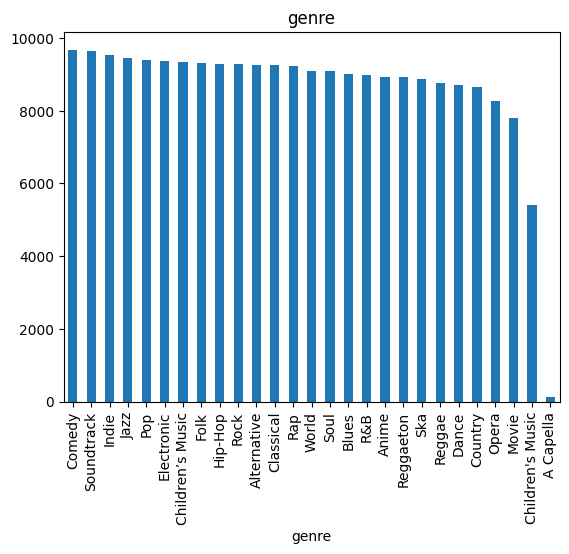

In [8]:
CountAndPlot(df, 'genre')

**Insight:**

Terdapat genre musik Children's Music yang muncul dua kali dengan jumlah berbeda, perlu dilakukan analisis lebih lanjut

# Data Preprocessing

Pada tahap ini, dilakukan pembersihan data menangani missing values, mengatasi kedua nama genre yang mirip, dan memilih fitur yang relevan. Proses ini bertujuan untuk memastikan bahwa data yang digunakan bersih dan siap untuk dianalisis lebih lanjut.

## Mengatasi Missing Value

Dilakukan drop pada baris yang terdapat missing value

In [9]:
df = df.dropna(subset=['track_name'])

In [10]:
df.isnull().sum()

,0
genre,0
artist_name,0
track_name,0
track_id,0
popularity,0
acousticness,0
danceability,0
duration_ms,0
energy,0
instrumentalness,0


**Insight:**

Tidak terdapat missing value, dapat dilanjutkan untuk analissi selanjutnya

## Menangani 2 Nama Genre Music yang mirip

Dilakukan analisis mengenai kedua genre music yakni Children’s Music dan Children's Music, apakah hanya terjadi duplikat atau merupakan genre yang berbeda

- Kedua nama fitur berbeda, `Children’s Music` menggunakan petik melengkung dan `Children's Music`menggunakan petik biasa

### Memeriksa isi dari kedua genre

In [11]:
df[df['genre'].str.contains("Children", case=False, na=False)]['genre'].value_counts()

,count
genre,
Children’s Music,9353
Children's Music,5403


**Insight:**

Terlihat isi dari kedua genre berbeda, mengindikasikan bukan data duplikasi

### Memeriksa kesamaan isi data dari track_name dan track_id

In [12]:
df_child1 = df[df['genre'] == "Children’s Music"]
df_child2 = df[df['genre'] == "Children's Music"]

same_tracks = pd.merge(df_child1, df_child2, on='track_name', how='inner')
print(same_tracks[['track_name', 'artist_name_x', 'artist_name_y']])


           track_name          artist_name_x                  artist_name_y
0    Under The Bridge  Red Hot Chili Peppers                          Radha
1             Honesty            Pink Sweat$         Children Songs Company
2     All Summer Long               Kid Rock  Music For Little People Choir
3          You And Me              Lifehouse                      Jen Gould
4              Switch                  6LACK                    Juice Music
..                ...                    ...                            ...
207             Waves         Electric Guest                    Juice Music
208           Forever               Kid Rock                The Wonder Kids
209         Satisfied                 Aranda                The Wonder Kids
210             Waves      Portugal. The Man                    Juice Music
211         Goodnight      Benny The Butcher               Music with Brian

[212 rows x 3 columns]


**Insight:**

Diperoleh bahwa kedua genre memiliki beberapa entri dengan judul lagu yang sama namun dinyanyikan oleh artis yang berbeda. Hal ini kemungkinan disebabkan oleh perbedaan versi lagu, seperti versi asli dan cover.

Oleh karena itu, akan dilakukan generalisasi atau standarisasi nama genre untuk menjaga konsistensi data. Namun, data tidak akan dihapus karena meskipun judul lagunya sama, karena kontennya berbeda, sehingga tetap relevan untuk dianalisis secara terpisah.

### Standarisasi Nama Genre

In [13]:
df['genre'] = df['genre'].replace({'Children’s Music': "Children's Music"})

## Mengambil Subset Dataset Secara Acak

Karena ukuran dataset yang sangat besar membutuhkan waktu komputasi yang lama dan ruang penyimpanan yang besar, maka diputuskan untuk mengambil subset data sebanyak >= 10.000 baris.

Pemilihan subset dilakukan secara acak, kecuali untuk data dengan genre yang jarang muncul, seperti `"A Capella"`, yang akan dipertahankan seluruhnya agar tidak hilang dari analisis. Sementara itu, data dari genre lain akan diambil secara acak hingga total data mencapai batas 10.000 baris.

In [14]:
genre_list = ['Children’s Music','Folk', 'Comedy', 'Jazz', 'Ska', 'Soundtrack', 'Alternative', 'Hip-Hop', 'Pop', 'World',
              'Indie', 'Anime', 'Rap', 'Electronic', 'Classical', 'Reggaeton', 'Rock', 'Reggae',
              'Country', 'Soul', 'Blues', 'Opera', 'R&B', 'Movie', 'Dance']

df_sampled = df[df['genre'].isin(genre_list)].sample(10000, random_state=42)

df_extra = df[df['genre'].isin(["A Capella"])]

df_new = pd.concat([df_sampled, df_extra], ignore_index=True)

In [15]:
def CountAndPlot(df, feature):
  count = df_new[feature].value_counts()
  percent = 100*df[feature].value_counts(normalize=True)
  samples = pd.DataFrame({'Sample Count':count, 'Percentage':percent.round(1)})
  print(samples)
  count.plot(kind='bar', title=feature)

             Sample Count  Percentage
genre                                
Comedy                452         4.5
Indie                 452         4.5
Soundtrack            449         4.4
Pop                   445         4.4
Folk                  444         4.4
Jazz                  436         4.3
Reggae                430         4.2
Rap                   430         4.2
Anime                 428         4.2
Electronic            420         4.2
Alternative           418         4.1
Ska                   418         4.1
Rock                  417         4.1
R&B                   412         4.1
Classical             410         4.1
Hip-Hop               409         4.0
Soul                  404         4.0
Country               403         4.0
Dance                 399         3.9
Reggaeton             398         3.9
Blues                 395         3.9
World                 395         3.9
Opera                 375         3.7
Movie                 361         3.6
A Capella   

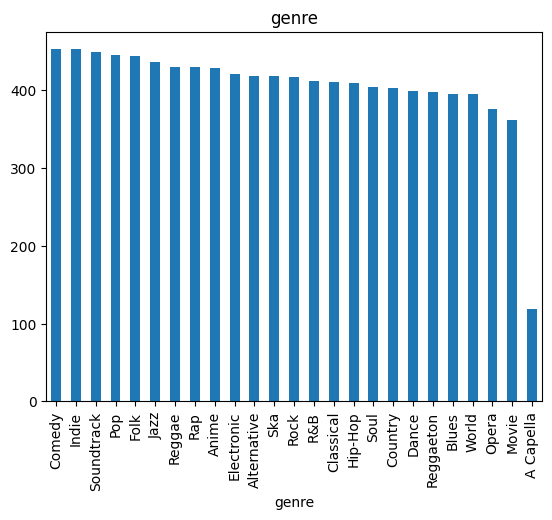

In [16]:
CountAndPlot(df_new, 'genre')

**Insight:**

Diperoleh bahwa genre `"A Capella"` merupakan genre dengan data yang tersedikit, namun hal ini tetap akan dipertahankan untuk memberikan variasi pada genre

## Mengambil fitur yang relevan



Dataset memiliki total 18 fitur, namun tidak semuanya digunakan dalam proses pembuatan sistem rekomendasi. Pada proyek ini, sistem rekomendasi dikembangkan tidak hanya berdasarkan kemiripan 'Penyanyi' dan 'Judul Lagu', tetapi juga mempertimbangkan atribut-atribut audio dari setiap lagu.

Fitur-fitur yang dipilih mencakup:  
- `track_id`, `artist_name`, `track_name`, `genre`,  
- serta fitur audio seperti `acousticness`, `danceability`, `energy`, `instrumentalness`, `loudness`, `speechiness`, `tempo`, dan `valence`.

Pemilihan fitur ini bertujuan untuk menghasilkan rekomendasi lagu yang lebih relevan secara musikalitas dan karakteristik audio, bukan sekadar berdasarkan kemiripan teks atau artis.

In [17]:
features = [
    'track_id','artist_name','track_name','genre','acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'tempo', 'valence']

data = df_new[features]

In [18]:
audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'tempo', 'valence']

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10119 entries, 0 to 10118
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          10119 non-null  object 
 1   artist_name       10119 non-null  object 
 2   track_name        10119 non-null  object 
 3   genre             10119 non-null  object 
 4   acousticness      10119 non-null  float64
 5   danceability      10119 non-null  float64
 6   energy            10119 non-null  float64
 7   instrumentalness  10119 non-null  float64
 8   loudness          10119 non-null  float64
 9   speechiness       10119 non-null  float64
 10  tempo             10119 non-null  float64
 11  valence           10119 non-null  float64
dtypes: float64(8), object(4)
memory usage: 948.8+ KB


In [20]:
data.describe()

,acousticness,danceability,energy,instrumentalness,loudness,speechiness,tempo,valence
count,10119.000000,10119.000000,10119.000000,10119.000000,10119.000000,10119.000000,10119.000000,10119.000000
mean,0.378677,0.550167,0.565209,0.149067,-9.715239,0.120388,117.401576,0.450149
std,0.358894,0.184795,0.267095,0.305322,6.138400,0.187109,30.783877,0.260773
min,0.000001,0.060500,0.000259,0.000000,-46.507000,0.022900,35.341000,0.000000
25%,0.041450,0.432000,0.374500,0.000000,-11.978500,0.036500,92.474000,0.229500
50%,0.241000,0.569000,0.595000,0.000047,-7.814000,0.050100,115.499000,0.441000
75%,0.751000,0.688000,0.787000,0.032900,-5.518000,0.103000,139.043500,0.652000
max,0.996000,0.980000,0.999000,0.989000,1.342000,0.964000,232.602000,0.989000


**Insight:**

Dari hasil visualisasi dan eksplorasi data, ditemukan bahwa fitur `loudness` dan `tempo` memiliki skala dan distribusi nilai yang berbeda dibandingkan fitur lainnya. Perbedaan skala ini dapat menyebabkan bias dalam perhitungan kemiripan (cosine similarity), yakni fitur dengan skala besar akan memiliki pengaruh yang lebih besar.

Untuk mengatasi hal ini, diperlukan proses normalisasi atau standarisasi agar seluruh fitur berada dalam skala yang seragam. Dengan demikian, semua fitur dapat memberikan kontribusi yang seimbang dalam proses rekomendasi.

**Kesimpulan Akhir dari Proses Data Preprocessing**

Dataset telah dibersihkan dari missing value, nama genre yang mirip, dan telah mensortir fitur yang relevan digunakan dan telah disimpan dalam variabel `data`



# Data Preparation

Pada tahap selanjutnya dilakukan normalisasi nilai fitur audio dengan MinmAxScaler, membuat kombinasi nama, TF-IDF vektorizer dan penggabungan

## Normalisasi Fitur Audio



Dalam proyek ini digunakan metode **MinMaxScaler** untuk mengubah semua nilai fitur ke dalam rentang [0, 1], sehingga tidak ada fitur yang mendominasi perhitungan kemiripan.


In [21]:
scaler = MinMaxScaler()
scaled_audio = scaler.fit_transform(data[audio_features])
data[audio_features] = scaler.fit_transform(data[audio_features])

<ipython-input-21-65208dce6c2d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[audio_features] = scaler.fit_transform(data[audio_features])


In [22]:
data.describe()

,acousticness,danceability,energy,instrumentalness,loudness,speechiness,tempo,valence
count,10119.000000,10119.000000,10119.000000,10119.000000,10119.000000,10119.000000,10119.000000,10119.000000
mean,0.380197,0.532536,0.565662,0.150725,0.768914,0.103589,0.416000,0.455156
std,0.360336,0.200974,0.267432,0.308718,0.128287,0.198819,0.156057,0.263673
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.041615,0.404024,0.374713,0.000000,0.721614,0.014451,0.289632,0.232053
50%,0.241967,0.553018,0.595491,0.000047,0.808648,0.028902,0.406355,0.445905
75%,0.754016,0.682436,0.787733,0.033266,0.856632,0.085113,0.525712,0.659252
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Insight:**

Dapat dilihat bahwa seluruh fitur memiliki skala dan distribusi nilai yang sama, sehingga bisa dilanjutkan ke tahap selanjutnya

## Membuat Kombinasi Nama

Hal ini dilakukan agar TF-IDF dapat menghitung kemiripan berdasarkan dua aspek yakni `artist_name` dan `genre`, dan menyimpannya dalam `'combined_text'`

In [23]:
data['combined_text'] = data['artist_name'] + ' ' + data['genre']

<ipython-input-23-889c2547da9b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['combined_text'] = data['artist_name'] + ' ' + data['genre']


## TF-IDF Vectorizer

Saat mencari sebuah lagu, agar sistem akan merekomendasikan lagu-lagu lain yang mirip baik dari segi penyanyi maupun karakteristik audio seperti `acousticness, danceability, energy, valence`, dan `tempo`, maka dilakukan penggabungan dari TF-IDF dan `scaled_audio`.

In [24]:
tf = TfidfVectorizer()
tfidf_matrix = tf.fit_transform(data['combined_text'])

### Penggabungan

In [25]:
hybrid_matrix = hstack([tfidf_matrix, scaled_audio])

# Model Development Content Based Filtering

Content-Based Filtering sangat cocok untuk sistem rekomendasi berbasis konten yang tidak melibatkan perilaku pengguna secara langsung, serta mempermudah interpretasi hasil karena rekomendasi diberikan berdasarkan kemiripan konten antar lagu. Namun metode ini memiliki kelemahan, adapauun kelemahan utamanya adalah masalah _overspecialization_, di mana sistem hanya merekomendasikan item yang sangat mirip dengan yang sudah dikenal atau disukai sebelumnya, sehingga mengurangi keberagaman rekomendasi. Selain itu, metode ini tidak dapat menangkap preferensi kolektif dari pengguna lain karena tidak melibatkan data komunitas atau perilaku pengguna secara luas. Kekurangan lainnya adalah ketergantungan tinggi terhadap kualitas dan kelengkapan fitur konten.

## Cosine Similarity

Gunakan teknik cosine similarity untuk menemukan lagu-lagu yang mirip secara musikal dengan lagu yang dicari

In [26]:
cosine_sim = cosine_similarity(hybrid_matrix)
cosine_sim

array([[1.        , 0.52906616, 0.71870196, ..., 0.44427245, 0.38984661,
        0.3686466 ],
       [0.52906616, 1.        , 0.53753828, ..., 0.29898606, 0.25318883,
        0.23345297],
       [0.71870196, 0.53753828, 1.        , ..., 0.37734181, 0.31531785,
        0.29198483],
       ...,
       [0.44427245, 0.29898606, 0.37734181, ..., 1.        , 0.99595218,
        0.98668431],
       [0.38984661, 0.25318883, 0.31531785, ..., 0.99595218, 1.        ,
        0.99573726],
       [0.3686466 , 0.23345297, 0.29198483, ..., 0.98668431, 0.99573726,
        1.        ]])

## Membuat Dictionary Berisi 10 Lagu Paling Mirip

Menyusun top 10 rekomendasi lagu yang paling mirip untuk setiap lagu berdasarkan skor cosine similarity

In [27]:
top_k_sim = {}

for i in range(cosine_sim.shape[0]):
    top_indices = np.argsort(cosine_sim[i])[::-1][:10]
    key = data['track_name'].iloc[i] + '-' + data['artist_name'].iloc[i]
    similar_items = data.iloc[top_indices][['track_name', 'artist_name']].apply(
        lambda x: f"{x['track_name']} - {x['artist_name']}", axis=1).tolist()
    top_k_sim[key] = similar_items

## Mendapatkan Rekomendasi

Memberikan rekomendasi lagu yang mirip dengan lagu input, berdasarkan kemiripan fitur (hasil dari cosine_similarity), dengan referensi pada `track_name` dan `artist_name`.

In [28]:
def music_recommendations(track_name_input, artist_input, similarity_data=top_k_sim, k=5):
    """
    Rekomendasikan lagu mirip berdasarkan track dan artist
    """
    key = f"{track_name_input}-{artist_input}"

    if key not in similarity_data:
        print("Lagu tidak ditemukan di data.")
        return pd.DataFrame()

    recommended_keys = similarity_data[key][:k]

    recommended_data = []
    for item in recommended_keys:
        parts = item.rsplit(" - ", 1)
        if len(parts) == 2:
            recommended_data.append(parts)
        else:
            print(f"Warning: Skipping item '{item}' as it could not be parsed into track and artist.")
            continue

    if not recommended_data:
        print("No valid recommendations found after parsing.")
        return pd.DataFrame()

    recommended_df = pd.DataFrame(recommended_data, columns=["track_name", "artist_name"])

    return pd.merge(recommended_df, data, on=["track_name", "artist_name"], how="left")[[
         'track_id','artist_name','track_name','genre','acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'tempo', 'valence'
    ]]

In [29]:
music_recommendations("How to Be Married", "Jackie Kashian")

,track_id,artist_name,track_name,genre,acousticness,danceability,energy,instrumentalness,loudness,speechiness,tempo,valence
0,0a4lqrikZRONK8GFqRgRoi,Jackie Kashian,How to Be Married,Comedy,0.676706,0.704187,0.757695,0.0,0.802148,0.961747,0.203107,0.732053
1,3doVn4FNryNBnKjGFx2bMC,Jackie Kashian,Bite Suit,Comedy,0.668674,0.708537,0.700623,0.0,0.825096,0.961747,0.389149,0.702730
2,5ahc9pNqLSwDAF5PJZMo9S,T.J. Miller,"Episode 6 ""Smokes, Jokes And Froze-Tokes""",Comedy,0.838353,0.510604,0.743677,0.0,0.827039,0.979811,0.167757,0.588473
3,6sauVvIY5BNHLjxoyDoSju,Tommy Ryman,Toots and Farts,Comedy,0.783132,0.683524,0.857821,0.0,0.821125,0.948996,0.259631,0.564206
4,0u6cXeKT83UPslAot9FwQA,Sinbad,Life Is Short,Comedy,0.734939,0.592170,0.674590,0.0,0.816172,0.927744,0.384774,0.625885


## Evaluation

### Visual Similarity Inspection

Membandingkan nilai fitur audio (seperti acousticness, danceability, dll) antara lagu input dan lagu hasil rekomendasi.

Visualisasi ini memudahkan untuk melihat seberapa mirip pola fitur kedua lagu dalam bentuk garis.

**Cara Kerja Visual Similarity Inspection**

- Ekstraksi Fitur Audio:

  Ambil nilai dari fitur-fitur audio
  
- Plotting Nilai Fitur:
   - Visualisasi berupa plot garis (line plot), sumbu-X merepresentasikan nama fitur audio, dan sumbu-Y adalah nilai normalisasi dari masing-masing fitur. Lagu input digambarkan dengan satu garis, dan setiap lagu rekomendasi digambarkan dengan garis lain

- Perbandingan Visual:

  Semakin mirip bentuk kurva/grafiknya, semakin mirip juga karakteristik musikal dari lagu-lagu tersebut.

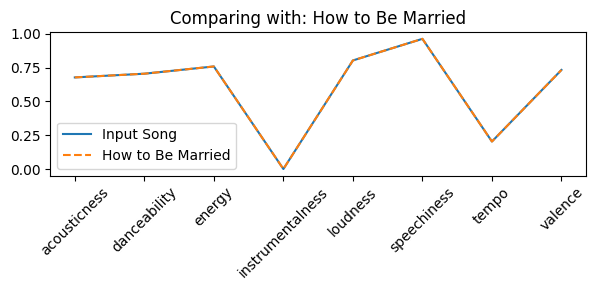

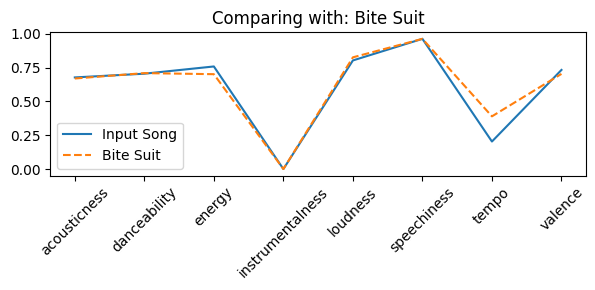

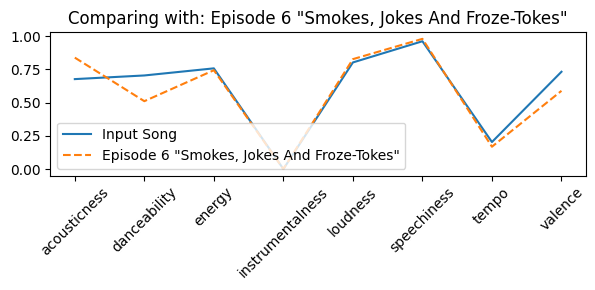

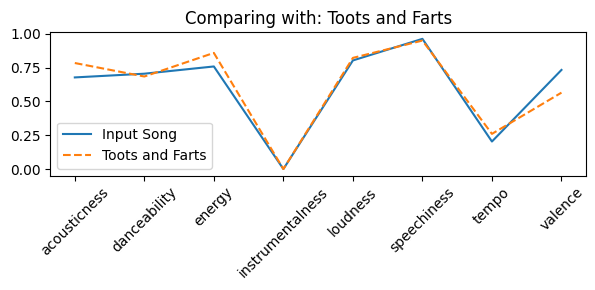

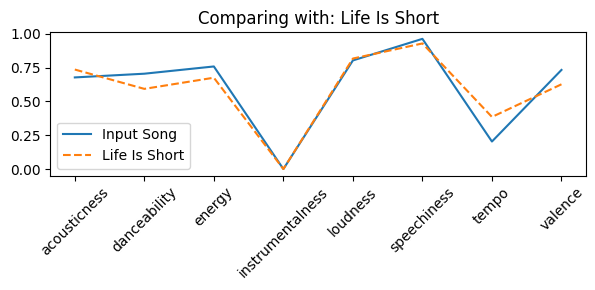

In [30]:
input_track = data[(data['track_name'] == 'How to Be Married') & (data['artist_name'] == 'Jackie Kashian')][audio_features].iloc[0]
rekomendasi = music_recommendations("How to Be Married", "Jackie Kashian")

for idx, row in rekomendasi.iterrows():
    plt.figure(figsize=(6,3))
    plt.plot(audio_features, input_track.values, label='Input Song')
    plt.plot(audio_features, row[audio_features].values, label=row['track_name'], linestyle='--')
    plt.legend()
    plt.title(f"Comparing with: {row['track_name']}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


**Salah satu interpretasi dari grafik diatas:**

Rekomendasi "Life Is Short" cukup mirip dengan lagu How to Be Married karena memiliki kesamaan pada aspek instrumental, keras suara, dan unsur bicara, meskipun sedikit berbeda dalam tempo dan suasana emosional (valence).

### Mean Absolute Error (MAE) antar fitur

Untuk mengukur kinerja sistem rekomendasi lagu berbasis konten, digunakan metrik Mean Absolute Error (MAE). Metrik ini mengukur seberapa besar rata-rata perbedaan absolut antara fitur-fitur lagu input dan lagu yang direkomendasikan.


**Rumus MAE:**

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} | y_i - \hat{y}_i |
$$

**Keterangan:**
- yᵢ: nilai fitur lagu asli
- ŷᵢ: nilai fitur lagu hasil rekomendasi
- n: jumlah fitur audio yang dibandingkan

**Dengan cara kerja:**

- Untuk setiap lagu rekomendasi, dibandingkan nilai fitur audionya dengan lagu input.

- Seluruh selisih absolut dihitung untuk fitur seperti acousticness, danceability, energy, valence, dan tempo.

- MAE yang lebih kecil menunjukkan bahwa fitur-fitur lagu tersebut memiliki kriteria yang sangat mirip dengan lagu input.

In [31]:
if not rekomendasi.empty:
    for index, row in rekomendasi.iterrows():
        recommended_song_features = row[audio_features]

        mae = mean_absolute_error(input_track.values, recommended_song_features.values)

        print(f"Mean Absolute Error (MAE) untuk '{row['track_name']}' - '{row['artist_name']}': {mae:.4f}")
else:
    print("Tidak ada rekomendasi")

Mean Absolute Error (MAE) untuk 'How to Be Married' - 'Jackie Kashian': 0.0000
Mean Absolute Error (MAE) untuk 'Bite Suit' - 'Jackie Kashian': 0.0385
Mean Absolute Error (MAE) untuk 'Episode 6 "Smokes, Jokes And Froze-Tokes"' - 'T.J. Miller': 0.0739
Mean Absolute Error (MAE) untuk 'Toots and Farts' - 'Tommy Ryman': 0.0604
Mean Absolute Error (MAE) untuk 'Life Is Short' - 'Sinbad': 0.0737


**Insight:**

- Diperoleh nilai MAE dari kemiripan lagu 'How to Be Married' dengan 'How to Be Married' adalah 0, yang artinya sama persis karena memang membandingkan dengan lagu yang sama
- Diperoleh nilai MAE dari kemiripan lagu 'How to Be Married' dengan 'Bite Suit' adalah 0.0385, menunjukkan bahwa rekomendasi lagu 'Bite Suit' **sangat mirip** dengan lagu "How to Be Married".
- Diperoleh nilai MAE dari kemiripan lagu 'How to Be Married' dengan 'Episode 6 "Smokes, Jokes And Froze-Tokes"' - 'T.J. Miller' adalah 0.0739, menunjukkan bahwa rekomendasi lagu 'Episode 6 "Smokes, Jokes And Froze-Tokes"' - 'T.J. Miller' **cukup mirip** dengan lagu "How to Be Married".
- Diperoleh nilai MAE dari kemiripan lagu 'How to Be Married' dengan 'Toots and Farts' adalah 0.0604, menunjukkan bahwa rekomendasi lagu 'Toots and Farts' **cukup mirip** dengan lagu "How to Be Married".
- Diperoleh nilai MAE dari kemiripan lagu 'How to Be Married' dengan 'Life Is Short' - 'Sinbad' adalah 0.0737, menunjukkan bahwa rekomendasi lagu 'Life Is Short' - 'Sinbad' **cukup mirip** dengan lagu "How to Be Married".

Diantara kedua bentuk evaluasi, metode evaluasi dengan MAE menunjukkan hasil yang dapat dipercaya dibandingkan hanya dengan melihat visualisasinya.